In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import IPython.display
import pickle
import os
from tqdm import tqdm
import collections
import json
import torch
import torch.nn.functional as F
import sys
import numpy as np


sys.path.append('..')
from src.train import Trainer
from src.utils import set_requires_grad
from clsmodel import mnist, stl10, afhq

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


INFO: Using numpy backend


In [2]:
# load exp config
model_path = '/vol/biomedic2/agk21/PhDLogs/codes/SYB3/LOGS/MNISTL1/models/best.pth'

#data-folder-path
folder_path = '/vol/biomedic2/agk21/PhDLogs/datasets/MNIST'
# folder_path = '/vol/biomedic2/agk21/PhDLogs/datasets/AFHQ/afhq'

config = json.load(open(os.path.join(os.path.dirname(os.path.dirname(model_path)), 'exp-config.json'), 'r'))

# config['classifier'] = afhq(32, True).cuda(0)
config['classifier'] = mnist(32, 'it').cuda(0)

model = Trainer(**config)
model.load_model(model_path)
model.eval()


# model defns
feature_extractor = model.feature_extractor
conti_classifier = model.classifier_baseline
dis_classifier = model.classifier_quantized
decoder = model.dec
codebook_sampler = model.modelclass


# set_requires_grad(classifier, False)
set_requires_grad(feature_extractor, False)
set_requires_grad(conti_classifier, False)
set_requires_grad(dis_classifier, False)
set_requires_grad(decoder, False)
set_requires_grad(codebook_sampler, False)
    

# required config variables 
image_size = model.input_size
latent_dim = model.latent_size
num_classes = model.nclasses

Building data loader with 16 workers
True
3 2 2 2
FeatureExtractor: Total number of trainable params: 0/28640
ContiClassifier: Total number of trainable params: 0/10250
codebook: Total number of trainable params: 87881/87881
DisClassifier: Total number of trainable params: 650/650
Decoder: Total number of trainable params: 5645571/5645571
Model loaded from /vol/biomedic2/agk21/PhDLogs/codes/SYB3/LOGS/MNISTL1/models/best.pth, loaded epoch:1 with stats: {'loss': 1.6632385, 'f1': 0.9908000000000001, 'acc': 0.9908000000000001, 'rloss': 0.011827702}


In [3]:
from src.dataset import get

batch_size = 16
train_loader, test_loader = get(batch_size, 
                      data_root = folder_path, 
                      train=True, val=True, 
                      input_size = image_size,
                      num_workers=10)


orig_images = []; orig_labels = []
for (img_batch, label_batch, *context_batch) in tqdm(test_loader):
    img_batch = img_batch.cuda(0)
    label_batch = label_batch.cuda(0)
    orig_images.extend(img_batch)
    orig_labels.extend(label_batch)


labels_ = np.array([lb.cpu().numpy() for lb in orig_labels])
# generate sample dataset
def get_sample_data(N_datapoints = 10): 
    sample_images = []; sample_labels = []
    for ci in range(num_classes):
        idxs = np.where(labels_ == ci)[0]
        randidxs = idxs[np.random.randint(0, len(idxs), N_datapoints//num_classes)]

        for idx in randidxs:
            sample_images.append(orig_images[idx].unsqueeze(0))
            sample_labels.append(orig_labels[idx].unsqueeze(0))

    sample_images = torch.cat(sample_images, dim = 0)
    sample_labels = torch.cat(sample_labels, dim = 0)
    return sample_images, sample_labels

Building data loader with 10 workers


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:03<00:00, 194.15it/s]


585


1001it [01:25, 11.73it/s]


220


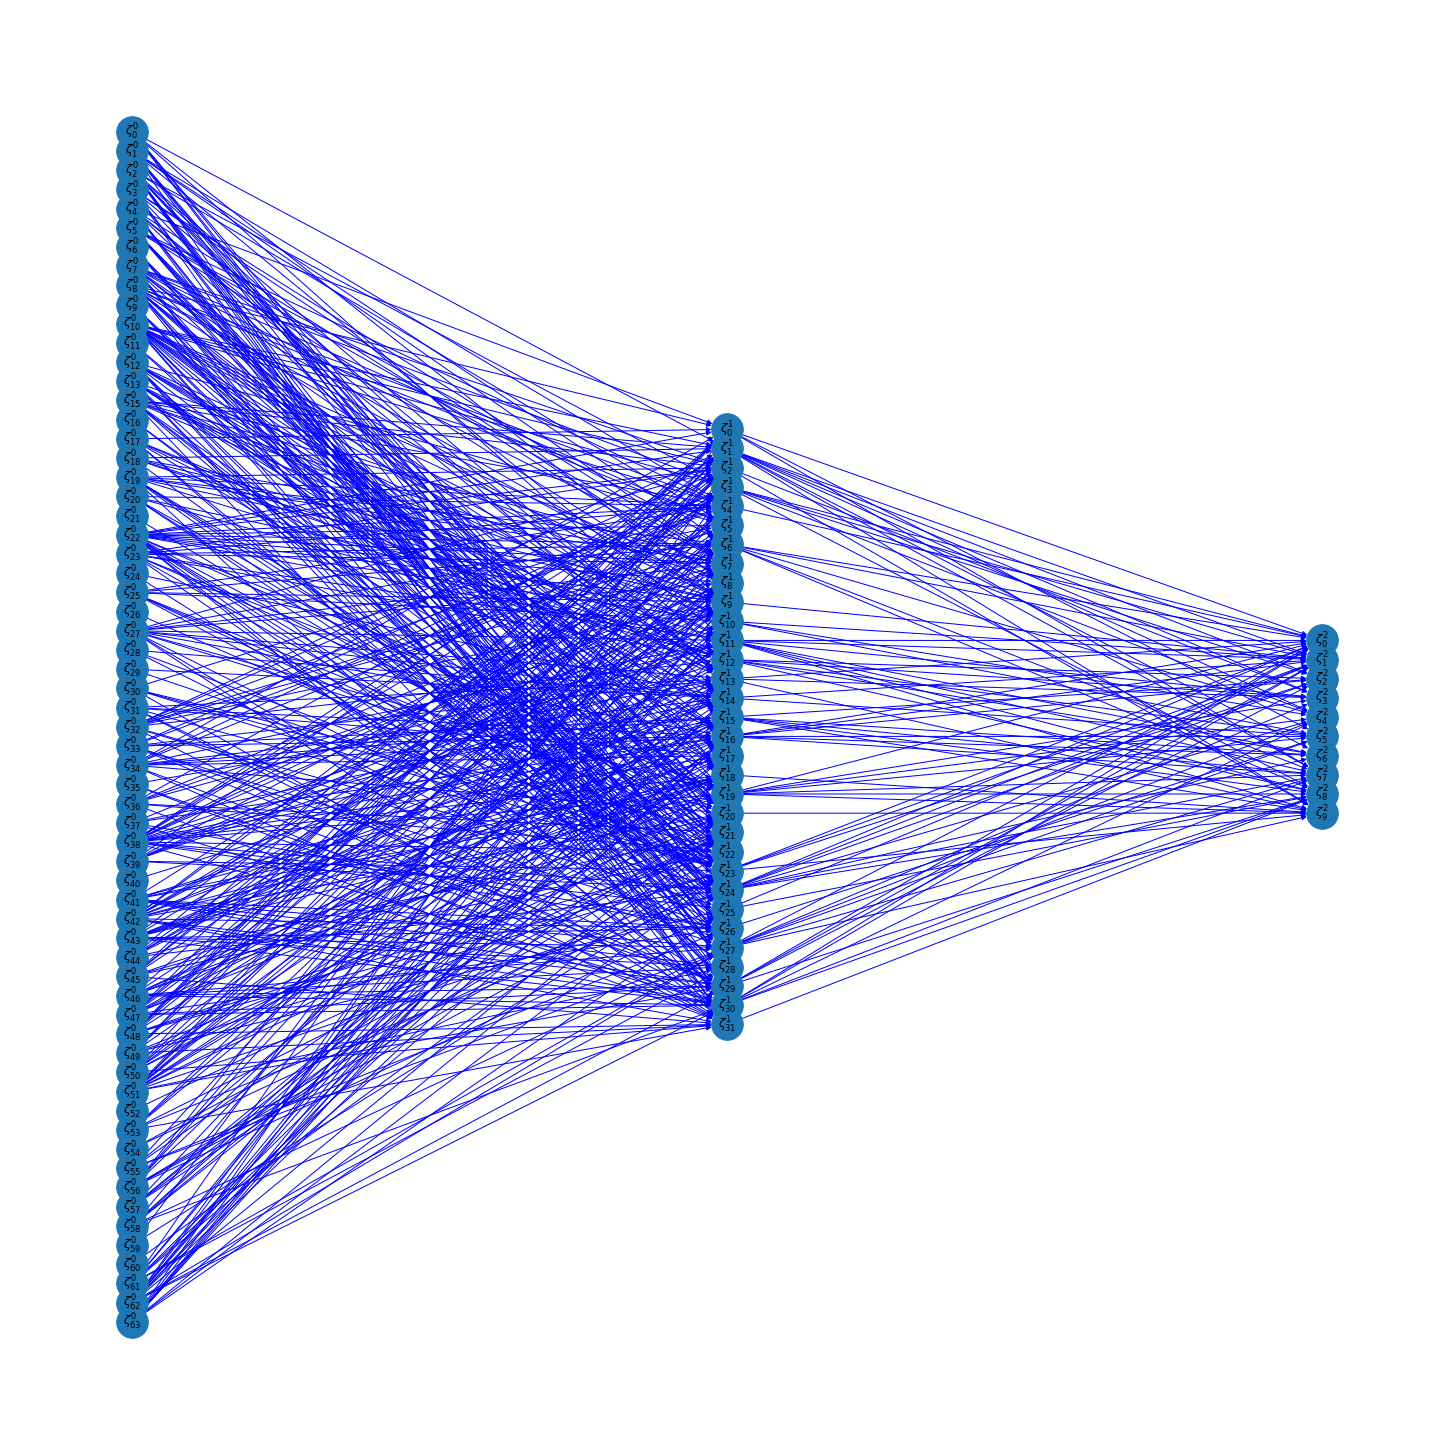

In [4]:
from src.inference import InductiveReasoningDT

inferer = InductiveReasoningDT(get_sample_data(100),
                               ncodebook_features = model.codebook_size,
                               nclasses = num_classes,
                               train_loader = train_loader,
                               feature_extractor = feature_extractor,
                               codebook = codebook_sampler,
                               classifier = dis_classifier,
                               decoder = decoder)

                               

In [5]:
codebook_sampler.reasoningLayers[0].weight

Parameter containing:
tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 1.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0')

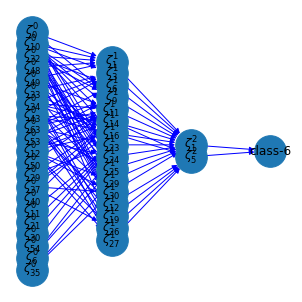

In [12]:
inferer.get_class_tree(6)

$\zeta^{2}_{1}$ ['$\\zeta^{1}_{1}$', '$\\zeta^{1}_{3}$', '$\\zeta^{1}_{6}$', '$\\zeta^{1}_{9}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{14}$', '$\\zeta^{1}_{16}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{25}$', '$\\zeta^{1}_{29}$', '$\\zeta^{1}_{30}$'] [ 0  3 25]
$\zeta^{2}_{5}$ ['$\\zeta^{1}_{12}$', '$\\zeta^{1}_{14}$', '$\\zeta^{1}_{16}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{26}$', '$\\zeta^{1}_{27}$'] [ 0  3 25]
$\zeta^{1}_{3}$ ['$\\zeta^{0}_{10}$', '$\\zeta^{0}_{33}$', '$\\zeta^{0}_{34}$', '$\\zeta^{0}_{43}$'] [ 0  6 10 12 14 15 16 18 22 30 32 34 35 37 38 39 41 43 45 47 48 50 53 54
 59 60 61 63]
$\zeta^{1}_{25}$ ['$\\zeta^{0}_{0}$', '$\\zeta^{0}_{6}$', '$\\zeta^{0}_{10}$', '$\\zeta^{0}_{32}$', '$\\zeta^{0}_{49}$', '$\\zeta^{0}_{63}$'] [ 0  6 10 12 14 15 16 18 22 30 32 34 35 37 38 39 41 43 45 47 48 50 53 54
 59 60 61 63]


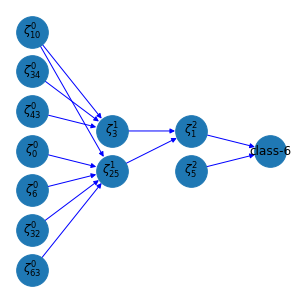

In [13]:
x,y = get_sample_data(num_classes)

class_idx = 6
x = x[class_idx].unsqueeze(0)

inferer.get_local_tree(class_idx, x)

$\zeta^{2}_{1}$ ['$\\zeta^{1}_{1}$', '$\\zeta^{1}_{3}$', '$\\zeta^{1}_{6}$', '$\\zeta^{1}_{9}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{14}$', '$\\zeta^{1}_{16}$', '$\\zeta^{1}_{23}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{25}$', '$\\zeta^{1}_{29}$', '$\\zeta^{1}_{30}$'] [ 0  3 25]
$\zeta^{2}_{5}$ ['$\\zeta^{1}_{12}$', '$\\zeta^{1}_{14}$', '$\\zeta^{1}_{16}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{26}$', '$\\zeta^{1}_{27}$'] [ 0  3 25]
$\zeta^{1}_{3}$ ['$\\zeta^{0}_{10}$', '$\\zeta^{0}_{33}$', '$\\zeta^{0}_{34}$', '$\\zeta^{0}_{43}$'] [ 0  6 10 12 14 15 16 18 22 30 32 34 35 37 38 39 41 43 45 47 48 50 53 54
 59 60 61 63]
$\zeta^{1}_{25}$ ['$\\zeta^{0}_{0}$', '$\\zeta^{0}_{6}$', '$\\zeta^{0}_{10}$', '$\\zeta^{0}_{32}$', '$\\zeta^{0}_{49}$', '$\\zeta^{0}_{63}$'] [ 0  6 10 12 14 15 16 18 22 30 32 34 35 37 38 39 41 43 45 47 48 50 53 54
 59 60 61 63]
*************** Level-0 heirarchy **************
class-6 <- $\zeta^{2}_{1}$,$\zeta^{2}_{5}$


<Figure size 288x288 with 0 Axes>

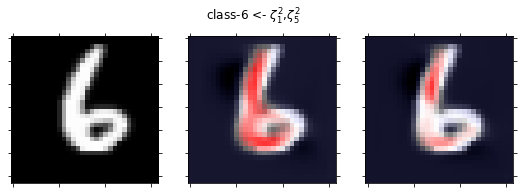

*************** Level-1 heirarchy **************
$\zeta^{2}_{1}$ <- $\zeta^{1}_{3}$,$\zeta^{1}_{25}$


<Figure size 432x288 with 0 Axes>

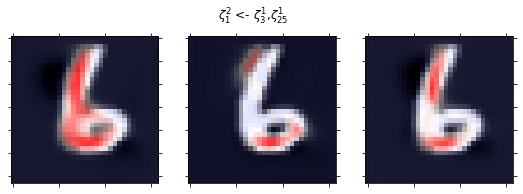

*************** Level-2 heirarchy **************
$\zeta^{1}_{3}$ <- $\zeta^{0}_{10}$,$\zeta^{0}_{34}$,$\zeta^{0}_{43}$


<Figure size 432x288 with 0 Axes>

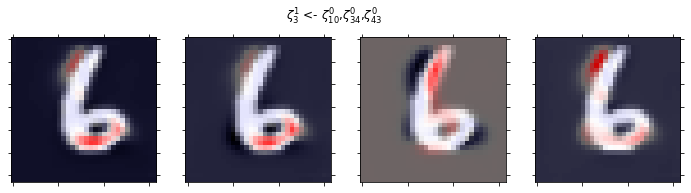

$\zeta^{1}_{25}$ <- $\zeta^{0}_{0}$,$\zeta^{0}_{6}$,$\zeta^{0}_{10}$,$\zeta^{0}_{32}$,$\zeta^{0}_{63}$


<Figure size 432x288 with 0 Axes>

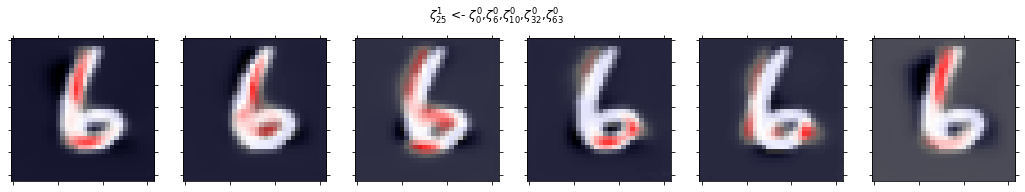

[['class-6 <- $\\zeta^{2}_{1}$,$\\zeta^{2}_{5}$'],
 ['$\\zeta^{2}_{1}$ <- $\\zeta^{1}_{3}$,$\\zeta^{1}_{25}$'],
 ['$\\zeta^{1}_{3}$ <- $\\zeta^{0}_{10}$,$\\zeta^{0}_{34}$,$\\zeta^{0}_{43}$',
  '$\\zeta^{1}_{25}$ <- $\\zeta^{0}_{0}$,$\\zeta^{0}_{6}$,$\\zeta^{0}_{10}$,$\\zeta^{0}_{32}$,$\\zeta^{0}_{63}$']]

In [14]:
inferer.query(class_idx, visual = x, local=True, overlay=True, save_path='.')